# Prepare matplotlib

In [2]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

Matplotlib is building the font cache; this may take a moment.


# Load data

In [3]:
# Functions for loading ewok data

ACC_KEY = "acc,none"
ERR_KEY = "acc_stderr,none"


def parse_ewok_data(path: Path):
    with path.open() as f:
        data = json.load(f)

    for subtask in data["group_subtasks"]["ewok_filtered"]:
        val = data["results"][subtask]
        yield subtask.split("_")[1], val[ACC_KEY], val[ERR_KEY]

# Load ewok data

In [4]:
# Load all ewok data -- by group
ACC_KEY = "acc,none"
ERR_KEY = "acc_stderr,none"

MAX_STEP = 20_000


def _get_data():
    for scale in ("tiny", "small"):
        for exp in ("decoder", "relora"):
            for step in range(0, MAX_STEP + 1, 1_000):
                path = Path(f"ewok_results/pico-{exp}-{scale}/step_{step}/ewok_results.json")
                for subtask, acc, err in parse_ewok_data(path):
                    yield (scale, rf"\texttt{{pico-{exp}}}", step, subtask, acc, err)


data = pd.DataFrame(_get_data(), columns=["Scale", "Model", "Step", "Subtask", "Acc", "Err"])
data["Step"] = data["Step"] // 1000

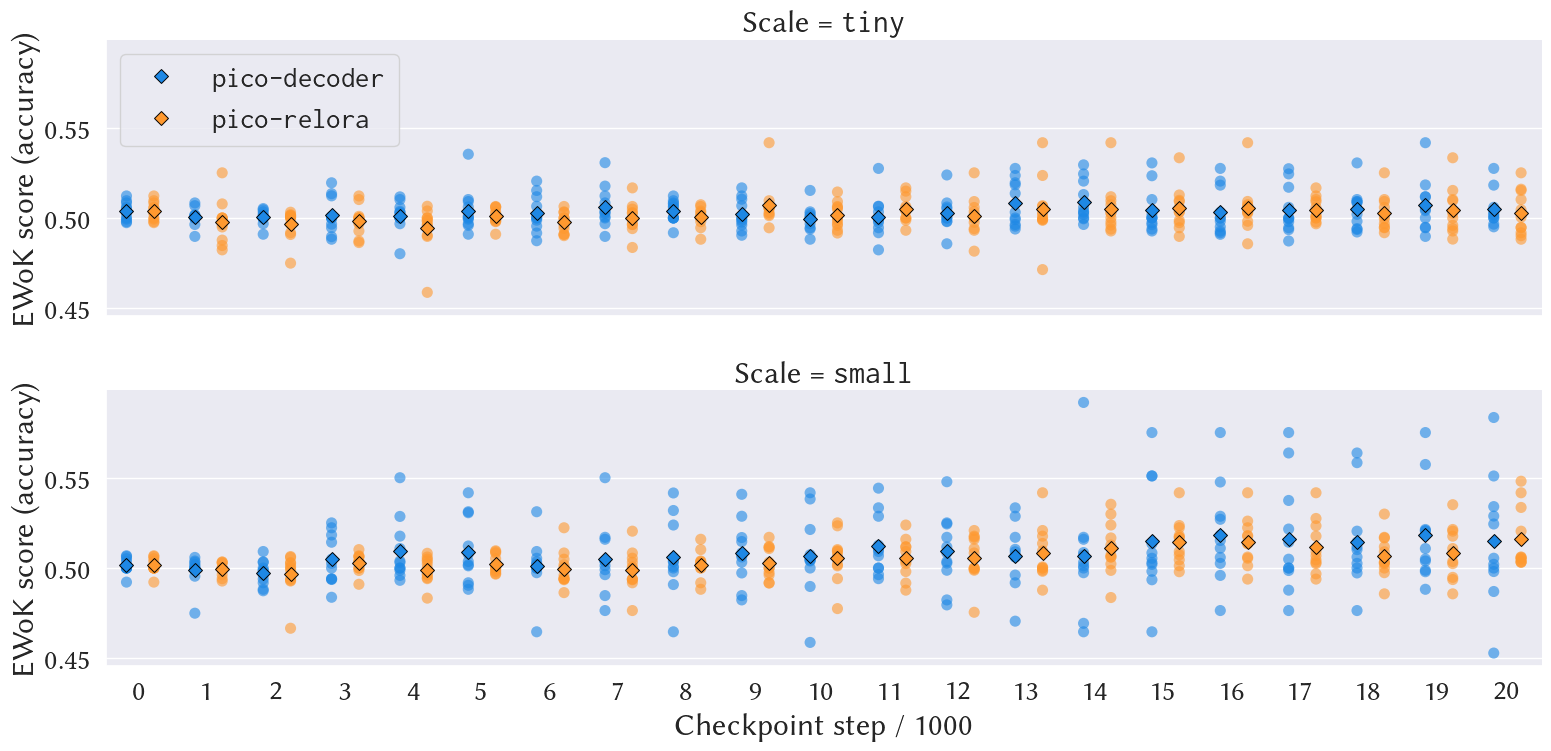

In [5]:
colors = ["#1E88E5", "#FF992F"]
models = list(data["Model"].unique())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 1.9


sns.set_theme(
    font_scale=font_scale,
    rc={"xtick.bottom": False, "axes.grid": "True", "axes.grid.which": "both", "text.usetex": True},
)

g = sns.FacetGrid(data=data, row="Scale", height=4, aspect=4, sharey=True)

g.map_dataframe(
    sns.stripplot,
    x="Step",
    y="Acc",
    hue="Model",
    size=size,
    alpha=0.6,
    jitter=False,
    dodge=dodge,
    palette=palette,
    legend=False,
    zorder=1,
)

# Add the pointplot with hue and dodge (for means)
g.map_dataframe(
    sns.pointplot,
    x="Step",
    y="Acc",
    hue="Model",
    dodge=dodge,
    markers="D",
    markersize=size - 1,
    markeredgecolor="black",
    markeredgewidth=0.7,
    err_kws={"linewidth": 0},
    linestyles="none",
    palette=palette,
    zorder=6,
)

g.set_titles(row_template=r"Scale = \texttt{{{row_name}}}")
g.set_axis_labels("Checkpoint step / 1000", "EWoK score (accuracy)")

for ax_idx, ax in enumerate(g.axes.flat):
    if ax_idx == 0:
        ax.legend(bbox_to_anchor=(0, 1), loc="upper left")

plt.savefig("../graphs/ewok_strip.pdf", bbox_inches="tight")
plt.show()

# Check whether results are random (p value statistical testing)

In [6]:
subtask_counts = {
    "agent-properties": 2240,
    "material-dynamics": 1560,
    "material-properties": 248,
    "physical-dynamics": 150,
    "physical-interactions": 560,
    "physical-relations": 830,
    "quantitative-properties": 380,
    "social-interactions": 350,
    "social-properties": 370,
    "social-relations": 1570,
    "spatial-relations": 490,
}

TOTAL_SUBTASKS = sum(subtask_counts.values())

In [7]:
full_res = {}
for scale in ("tiny", "small"):
    for ty in ("relora", "decoder"):
        for step in range(0, 20_001, 1_000):
            res_path = Path(f"ewok_results/pico-{ty}-{scale}/step_{step}/ewok_results.json")
            with res_path.open() as f:
                data = json.load(f)
            step_d = {}
            for subtask, count in subtask_counts.items():
                acc = data["results"][f"ewok_{subtask}_filtered"]["acc,none"]
                st_c = round(acc * count)
                step_d[subtask] = {"count": st_c, "acc": acc}

            full_res[f"{ty}-{scale}-{step}"] = step_d

In [8]:
p = 0.5
sig = 0.05
VERB = False
ckps_sig = 0
sig_res = []
for res, subtasks in full_res.items():
    if VERB:
        print(res)
    total_correct = 0
    num_sig = 0
    accs = []
    # subtasks
    for st, stv in subtasks.items():
        k = stv["count"]
        accs.append(stv["acc"])
        total_correct += k
        n = subtask_counts[st]
        p_val = sps.binom.cdf(k, n, p)
        if k > n * p:
            p_val = 1 - p_val

        p_val *= 2

        if p_val <= sig:
            num_sig += 1

        if VERB:
            print(f"{st} = acc: {k / n:.3f}, p: {p_val:.3f}")
    # whole task test

    p_val = sps.binom.cdf(total_correct, TOTAL_SUBTASKS, p)
    if total_correct > n * p:
        p_val = 1 - p_val

    p_val *= 2

    score = np.mean(accs)

    if p_val <= sig:
        ckps_sig += 1
        sig_res.append((res, score, num_sig))

    if VERB:
        print(f"whole task =  acc: {score:.3f}, p: {p_val:.3f}. sig tasks = {num_sig}")
        print()

print(f"TOTAL SIG: {ckps_sig}")
print(sig_res)

TOTAL SIG: 4
[('relora-small-16000', np.float64(0.5144832906780716), 1), ('relora-small-20000', np.float64(0.5159989473920152), 1), ('decoder-small-16000', np.float64(0.5185039398843266), 0), ('decoder-small-19000', np.float64(0.5181336712355828), 1)]


# With multiple p value correction

In [9]:
p = 0.5
sig = 0.05
ckps_sig = 0
p_vals = []
results_info = []
for res, subtasks in full_res.items():
    total_correct = 0
    num_sig = 0
    accs = []
    # subtasks
    for stv in subtasks.values():
        accs.append(stv["acc"])
        total_correct += stv["count"]

    # whole task test

    p_val = sps.binom.cdf(total_correct, TOTAL_SUBTASKS, p)
    if total_correct > n * p:
        p_val = 1 - p_val
    p_val *= 2

    if p_val > 1:
        p_val = 1

    p_vals.append(p_val)

    score = np.mean(accs)

    results_info.append((res, score))


adj_p_vals = sps.false_discovery_control(p_vals)
for adj_p, info in zip(adj_p_vals, results_info):
    # print(info, adj_p)
    if adj_p <= sig:
        print(f"{info[0]} is significant!")